In [1]:
from system import TradingEnv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
from itertools import chain
import numpy as np
import pandas as pd
import random
import math
from tqdm import tqdm

/home/aaruran/miniconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
e = TradingEnv()
STATE_DIM = len(e.reset())
print(f'STATE_DIM = {STATE_DIM}')
EMBED_DIM = 50 # from the dimensionality-reduced fastText model
ACTION_DIM = 3
EPISODES = 2000  # number of episodes
EPS_START = 0.9  # e-greedy threshold start value
EPS_END = 0.05  # e-greedy threshold end value
EPS_DECAY = 200  # e-greedy threshold decay
# GAMMA = 0.99  # Q-learning discount factor
LR = 0.1  # NN optimizer learning rate
HIDDEN_LAYER = 10  # NN hidden layer size
BATCH_SIZE = 16  # Q-learning batch size
TARGET_UPDATE = 100  # frequency of target update
BUFFER_SIZE = 100  # capacity of the replay buffer 

# if gpu is to be used
# use_cuda = torch.cuda.is_available()
use_cuda = False
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor
del e

STATE_DIM = 98


In [4]:
if use_cuda:
    print('GPU found and in use')
else:
    print('No GPU will be used')

No GPU will be used


# Simple QNetwork 
Corresponds to a fully connected network with two hidden layers

In [5]:
class QNetwork(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(STATE_DIM, HIDDEN_LAYER)
        self.l2 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
        self.l3 = nn.Linear(HIDDEN_LAYER, ACTION_DIM)
                

    def forward(self, x):
        """
            Computes the estimated Q-values for a given batch x
        """
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x      
    
    def sample_from_softmax_policy(self, batch_state):
        batch_q_values = self.forward(batch_state)
        batch_pi = F.softmax(batch_q_values, dim=1)
        batch_size = batch_pi.shape[0]
        batch_actions = torch.empty(batch_size, 1)
        for i in range(batch_size):
            pi = batch_pi[i, :]
            dist = torch.distributions.Categorical(pi)
            # Subtract 1, so batch_actions is in {-1, 0, 1}
            batch_actions[i, 0] = dist.sample().view(1,1) - 1
        if use_cuda:
            batch_actions = batch_actions.to(batch_state.get_device())
        return batch_actions.long()

# Generic Training Agent

In [43]:
class BaseAgent:
    def __init__(self, gamma=0.8):
        assert 0 < gamma < 1, f"Invalid gamma: {gamma}" 
        self.gamma = gamma
        self.memory = ReplayMemory(BUFFER_SIZE)
        self.history = pd.DataFrame()
        self.rewards_history = []
        self.steps_done = 0
        with open('sp500.txt', 'r') as src:
            self.filtered_tickers = src.read().split(',')
        
    def run_episode(self, environment):
        """
            Takes an env, and trains the agent until the environment
            reaches a terminal state (ie the training window is complete).
        """
        raise NotImplementedError()
    
    def plot_cumulative_discounted_rewards(self):
        rewards = np.array(self.rewards_history)
        discount_array = np.power(self.gamma, np.arange(rewards.shape[0]))
        plt.plot((discount_array[:, None] * rewards).sum(axis=1))
        plt.grid()
        plt.ylabel('Cumulative Discounted Rewards')
        plt.xlabel('Episode')

    def convert_action(self, action):
        """
            Takes action of shape 1 x 3, and converts into an integer in {-1, 0, 1}.
            This integer is the position short/hold/long respectively.
        """
        position = torch.argmax(action, dim=-1) - 1
        assert position in [-1,0,1]
        return position.item()
    
    def train(self, env_mode='dev', num_tickers=20, num_episodes = 5):
        """
            Trains the agent for num_tickers episodes, looping over the approved
            list of tickers. This is a convenience function.
        """
        if num_tickers == np.Inf:
            num_tickers = len(self.filtered_tickers)
        self.history = pd.DataFrame()
        for e in tqdm(range(num_episodes)):
            for i in range(num_tickers):
                ticker = self.filtered_tickers[ i % len(self.filtered_tickers)]
                env = TradingEnv(ticker=ticker, mode=env_mode)
                history = self.run_episode(env)
                history['ticker'] = ticker
                history['episode'] = e + 1
                self.history = pd.concat((self.history, history))

        self.history = self.history.set_index(['date', 'ticker', 'episode'])
        self.history = self.history.unstack(level=1).swaplevel(0,1,1)
        self.history = self.history.swaplevel(0,1,0).sort_index(1,0)
        self.plot_cumulative_discounted_rewards()

        
class DQN(BaseAgent):
    def __init__(self):
        super().__init__()
        self.model = QNetwork()
        self.target = QNetwork()
        self.optimizer = optim.SGD(self.model.parameters(), LR)

    def select_epsilon_greedy_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.target(state).data.max(1)[1].view(1, 1)
        else:
            return LongTensor([[random.randrange(3)]])
    
    def run_episode(self, environment):
        state = environment.reset()
        steps = 0
        action = None
        while True:
            state_tensor = FloatTensor([state])
            action = self.select_epsilon_greedy_action(state_tensor)
            position = self.convert_action(action)
            next_state, reward, done, _ = environment.step(position)
            
            self.memory.push(
                (
                    FloatTensor([state]),
                    action,  # action is already a tensor
                    FloatTensor([next_state]),
                    FloatTensor([reward]),
                    FloatTensor([int(done)])
                )
            )

            self.learn()
            if self.steps_done % TARGET_UPDATE == 0:
                self.target.load_state_dict(self.model.state_dict())
        
            state = next_state
            steps += 1
            if done:
                break
        self.rewards_history.append(environment.rewards_list)
        history = environment.close()
        return history

        
    def max_next_q_values(self, batch_next_state):
        # expected Q values are estimated from actions which gives maximum Q value
        return self.target(batch_next_state).detach().max(1)[0]
    
    def learn(self):
        if len(self.memory) <= BATCH_SIZE:
            return
        # random transition batch is taken from experience replay memory
        transitions = self.memory.sample(BATCH_SIZE)
        batch_state, batch_action, batch_next_state, batch_reward, batch_done = zip(*transitions)
        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))
        batch_done = Variable(torch.cat(batch_done))

        # current Q values are estimated by NN for all actions
        current_q_values = self.model(batch_state).gather(1, batch_action).squeeze()
        expected_future_rewards = self.max_next_q_values(batch_next_state)
        
        expected_q_values = batch_reward + (self.gamma * expected_future_rewards) * (1-batch_done)

        # loss is measured from error between current and newly expected Q values
        loss = F.mse_loss(current_q_values, expected_q_values)

        # backpropagation of loss to QNetwork
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    
# agent=DQN()
# env = TradingEnv()
# for i in range(10):
#     s = FloatTensor([env.reset()])
#     agent.steps_done=100
#     print(agent.select_epsilon_greedy_action(s))

# agent.run_episode(env)

In [44]:
agent=DQN()

  5%|▌         | 1/20 [00:01<00:20,  1.07s/it]

Updating target network
Updating target network
Updating target network
Updating target network


 10%|█         | 2/20 [00:01<00:18,  1.01s/it]

Updating target network
Updating target network


 15%|█▌        | 3/20 [00:02<00:16,  1.01it/s]

Updating target network
Updating target network
Updating target network


 20%|██        | 4/20 [00:03<00:15,  1.06it/s]

Updating target network
Updating target network
Updating target network


 25%|██▌       | 5/20 [00:04<00:13,  1.12it/s]

Updating target network
Updating target network


 30%|███       | 6/20 [00:05<00:13,  1.08it/s]

Updating target network
Updating target network


 35%|███▌      | 7/20 [00:06<00:12,  1.04it/s]

Updating target network


 40%|████      | 8/20 [00:07<00:11,  1.05it/s]

Updating target network
Updating target network
Updating target network
Updating target network


 45%|████▌     | 9/20 [00:08<00:09,  1.10it/s]

Updating target network


 50%|█████     | 10/20 [00:09<00:09,  1.11it/s]

Updating target network
Updating target network
Updating target network
Updating target network


 55%|█████▌    | 11/20 [00:10<00:08,  1.03it/s]

Updating target network


 60%|██████    | 12/20 [00:11<00:07,  1.02it/s]

Updating target network
Updating target network
Updating target network
Updating target network


 65%|██████▌   | 13/20 [00:12<00:06,  1.02it/s]

Updating target network
Updating target network
Updating target network


 70%|███████   | 14/20 [00:13<00:06,  1.00s/it]

Updating target network
Updating target network


 75%|███████▌  | 15/20 [00:14<00:04,  1.05it/s]

Updating target network


 80%|████████  | 16/20 [00:15<00:03,  1.07it/s]

Updating target network
Updating target network
Updating target network
Updating target network


 85%|████████▌ | 17/20 [00:16<00:03,  1.00s/it]

Updating target network
Updating target network


 90%|█████████ | 18/20 [00:17<00:01,  1.01it/s]

Updating target network
Updating target network
Updating target network


 95%|█████████▌| 19/20 [00:18<00:01,  1.01s/it]

Updating target network
Updating target network


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]

Updating target network


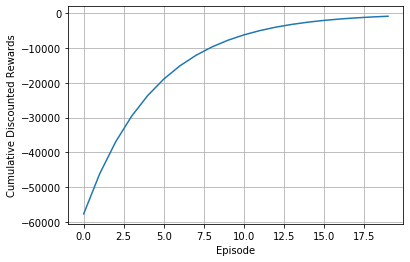

In [45]:
agent.train(num_tickers=1, num_episodes=20)

In [46]:
agent.history.sort_index(0).head(50)

ticker                 MMM                                   
                   actions      prices    returns     rewards
episode date                                                 
1       2014-01-06      -1  137.630005  -0.039978   -1.348460
        2014-01-07      -1  137.649994   1.999408 -168.488392
        2014-01-08      -1  136.630005   2.364693 -135.322048
        2014-01-09      -1  136.449997   2.914050 -219.611148
        2014-01-10      -1  136.179993   5.978091 -422.435737
        2014-01-13      -1  134.679993   0.277296 -216.309235
        2014-01-14      -1  137.410004  -1.788079  -12.746327
        2014-01-15      -1  138.440002  -1.234974 -202.372180
        2014-01-16      -1  138.160004   0.450919 -282.728844
        2014-01-17      -1  137.309998   1.093445 -205.889642
        2014-01-21      -1  136.990005   2.122301 -245.257212
        2014-01-22      -1  136.479996   5.719632 -516.257384
        2014-01-23      -1  134.710007  15.084935 -935.025181
        2014-01-24      -1  130.220001  17.894281 -268.827879
        2014-01-27      -1  128.960007  15.962066  -41.485987
        2014-01-28      -1  129.809998  14.974943  -45.281766
        2014-01-29      -1  130.250000  19.877178 -173.444133
        2014-01-30      -1  128.050003  19.554499  -48.737675
        2014-01-31      -1  128.190002  29.420748 -221.686676
        2014-02-03      -1  123.900002  22.486126  -55.322380
        2014-02-04      -1  126.720001  20.982359  -16.932338
        2014-02-05      -1  127.360001  17.400299  -22.063962
        2014-02-06      -1  128.899994  14.153545  -22.354932
        2014-02-07      -1  130.330002  15.552547  -76.770260
        2014-02-10      -1  129.699997  12.682541  -25.430404
        2014-02-11      -1  130.979996  13.869646 -103.355476
        2014-02-12      -1  130.440002  14.534625 -108.373196
        2014-02-13      -1  130.139999  10.125587  -96.646184
        2014-02-14      -1  132.119995  10.816786 -136.448002
        2014-02-18      -1  131.800003  13.508264 -198.580456
        2014-02-19      -1  130.559998  11.296497  -11.772385
        2014-02-20      -1  131.559998  11.274694  -90.830710
        2014-02-21      -1  131.570007   9.902695  -40.807607
        2014-02-24      -1  132.199997   8.328054  -10.849608
        2014-02-25      -1  132.929993   8.477373 -134.117497
        2014-02-26      -1  132.860001   5.316676 -109.072545
        2014-02-27      -1  134.339996   4.502141 -123.976806
        2014-02-28      -1  134.729996   9.734810 -495.803217
        2014-03-03      -1  132.210007   8.721698  -75.930819
        2014-03-04      -1  132.679993   6.217459  -24.489939
        2014-03-05      -1  133.850006   5.733794 -128.057559
        2014-03-06      -1  134.080002   5.670925 -160.579630
        2014-03-07      -1  134.110001   6.823060 -263.105400
        2014-03-10      -1  133.559998   9.040701 -331.028946
        2014-03-11      -1  132.509995   8.911943 -158.994381
        2014-03-12      -1  132.570007  12.684632 -541.096734
        2014-03-13      -1  130.809998  14.841841 -371.705702
        2014-03-14      -1  129.830002   9.389717 -156.972496
        2014-03-17      -1  132.270004   8.378258  -89.928231
        2014-03-18      -1  132.740005  11.604840 -354.134144

In [28]:
agent.history['MMM', 'actions'].max()

-1

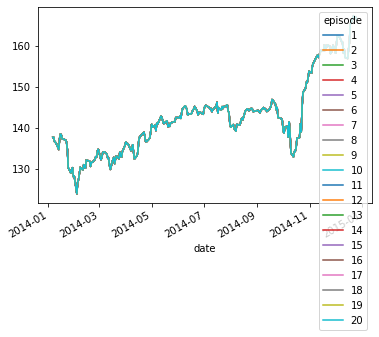

In [29]:
agent.history['MMM', 'prices'].unstack(level=0).plot()

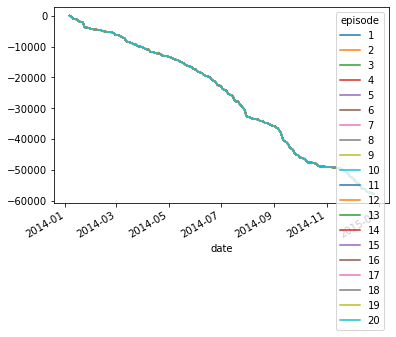

In [31]:
agent.history['MMM', 'rewards'].unstack(level=0).cumsum().plot()

In [32]:
for i, t in enumerate(agent.memory.memory):
    if i > 10:
        break
    action = t[1]
    print(f'action = {action}, ', end= ' ')
    position = agent.convert_action(action)
    print(f'position = {position}')

action = tensor([[1]]),  position = -1
action = tensor([[1]]),  position = -1
action = tensor([[1]]),  position = -1
action = tensor([[1]]),  position = -1
action = tensor([[1]]),  position = -1
action = tensor([[1]]),  position = -1
action = tensor([[1]]),  position = -1
action = tensor([[1]]),  position = -1
action = tensor([[1]]),  position = -1
action = tensor([[1]]),  position = -1
action = tensor([[1]]),  position = -1


In [33]:
STATE_DIM

98

In [42]:
dqn_agent = DQN()
for _ in range(10):
    random_state = FloatTensor([np.random.randn(98)])
    q_values = dqn_agent.target(random_state).detach()
    print(f'q_values = {q_values},')
    print(f'max_next_q_values = {dqn_agent.max_next_q_values(random_state)}')
    with torch.no_grad():
        optimal_action = q_values.data.max(1)[1].view(1, 1)
        print(f'optimal_action = {optimal_action}')

q_values = tensor([[-0.0536, -0.1901, -0.1533]]),
max_next_q_values = tensor([-0.0536])
optimal_action = tensor([[0]])
q_values = tensor([[ 0.0158,  0.2212, -0.0147]]),
max_next_q_values = tensor([0.2212])
optimal_action = tensor([[1]])
q_values = tensor([[-0.1137,  0.0271,  0.0738]]),
max_next_q_values = tensor([0.0738])
optimal_action = tensor([[2]])
q_values = tensor([[-0.1743,  0.0728,  0.0736]]),
max_next_q_values = tensor([0.0736])
optimal_action = tensor([[2]])
q_values = tensor([[-0.1569, -0.0673,  0.0188]]),
max_next_q_values = tensor([0.0188])
optimal_action = tensor([[2]])
q_values = tensor([[-0.0982,  0.0159,  0.0059]]),
max_next_q_values = tensor([0.0159])
optimal_action = tensor([[1]])
q_values = tensor([[-0.1393,  0.0204,  0.0376]]),
max_next_q_values = tensor([0.0376])
optimal_action = tensor([[2]])
q_values = tensor([[ 0.0235, -0.0563, -0.0867]]),
max_next_q_values = tensor([0.0235])
optimal_action = tensor([[0]])
q_values = tensor([[-0.1215,  0.0416,  0.0991]]),
max_n

In [ ]:
agent.history['MMM', 'rewards'].unstack(level=0)[1].apply(lambda x : x.item()).plot()

In [ ]:
plt.plot(agent.rewards_history[-1])

In [ ]:
plt.plot(agent.rewards_history[0])

In [ ]:
agent.plot_cumulative_discounted_rewards()

In [ ]:
# %load_ext line_profiler

In [ ]:
# e = TradingEnv()

In [ ]:
# %lprun -f agent.learn [agent.run_episode(e) for _ in range(10)]

In [ ]:
# _ = e.reset()
# %lprun -f e.step e.step(1)

In [ ]:
plt.plot(e.prices)

# Policy Network

In [ ]:
class PolicyNetwork(nn.Module):
    # for Policy-Gradient methods, e.g. actor-only and actor-critic methods
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, HIDDEN_LAYER)
        self.l2 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
        self.l3 = nn.Linear(HIDDEN_LAYER, 2) # 2, for the action

    def forward(self, x, d=1, get_log=False):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        if not get_log:
            x = F.softmax(self.l3(x), dim=d)
        else:
            x = F.log_softmax(self.l3(x), dim=d)
        return x
    
    def sample_from_softmax_policy(self, batch_state):
        batch_pi = self.forward(batch_state)
        batch_size = batch_pi.shape[0]
        actions = torch.empty(batch_size, 1)
        for i in range(batch_size):
            pi = batch_pi[i, :]
            dist = torch.distributions.Categorical(pi)
            actions[i, 0] = dist.sample().view(1,1)
        if use_cuda:
            actions = actions.to(batch_state.get_device())
        return actions.long()

# p = PolicyNetwork()
# state = env.reset()
# state_tensor = FloatTensor([state]).cuda()
# p.cuda()
# p.forward(state_tensor, d=1), p.forward(state_tensor, d=-1)
# p.sample_from_softmax_policy(torch.cat(5*[state_tensor])).shape

# LongOnly Agent

In [ ]:
class LongOnlyAgent(BaseAgent):
    def __init__(self):
        super().__init__()
        
    def run_episode(self, environment):
        state = environment.reset()
        steps = 0
        position = 1
        while True:
#             if steps % 50 == 0:
#                 print(f'steps = {steps}')
            _, r, done, __ = environment.step(position)

            self.steps_done += 1
            steps += 1
            if done:
                break
        self.rewards_history.append(environment.rewards_list)
        return environment.close()

# long_agent = LongOnlyAgent()
# e = TradingEnv()
# long_agent.run_episode(e)
# # long_agent.rewards_history
# long_agent.run_episode(e)

In [ ]:
long_agent = LongOnlyAgent()

In [ ]:
long_agent.train(num_tickers=1)

In [ ]:
agent.plot_cumulative_discounted_rewards()

In [ ]:
class ModelBasedAgent(BaseAgent):
    def __init__(self):
        super().__init__()